<a href="https://colab.research.google.com/github/MyNameIsCalvinDavis/rowing_data/blob/main/Rowing_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

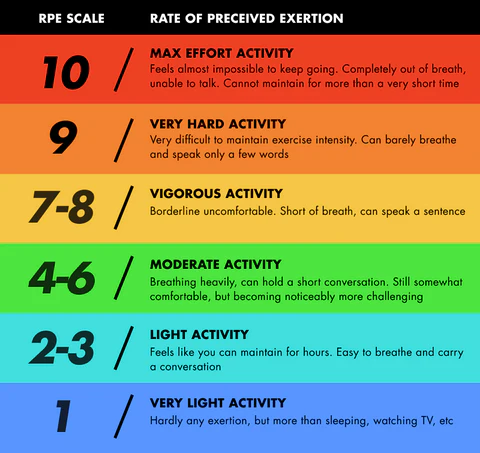

In [393]:
hrmax = 200
hrmin = 58

# Define an initial 2k time for the season
intl_benchmark = "7:50" # 1:57

UT2 = [.50, .60]
UT1 = [.60, .70]
AT = [.70, .80] # W Ranges
TR = [.80, 1.05]
AN = [1.05, 99]

# Boilerplate Calculations & Data Setup

In [394]:
# Seaborn config
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")

In [395]:
import pandas as pd
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', None)

# Rename concept2 data file to data.csv
for filename in os.scandir("."):
    if "concept" in filename.path:
        os.rename(filename.path, "data.csv")

# Select appropriate cols
df = pd.read_csv("data.csv")
print(df.columns)
df = df[["Date", "Work Distance", "Work Time (Seconds)", "Stroke Count", "Pace", "Avg Watts", "Total Cal", "Avg Heart Rate", 'Rest Time (Seconds)']]
df["Date"] = df["Date"].str[5:16]
df = df.rename(columns={"Work Distance":"Distance", "Work Time (Seconds)": "T(s)", "Rest Time (Seconds)": "R",
                        "Stroke Count": "Strokes", "Avg Watts": "W", "Avg Heart Rate": "HR"}).fillna(0)

Index(['Log ID', 'Date', 'Description', 'Work Time (Formatted)',
       'Work Time (Seconds)', 'Rest Time (Formatted)', 'Rest Time (Seconds)',
       'Work Distance', 'Rest Distance', 'Stroke Rate/Cadence', 'Stroke Count',
       'Pace', 'Avg Watts', 'Cal/Hour', 'Total Cal', 'Avg Heart Rate',
       'Drag Factor', 'Age', 'Weight', 'Type', 'Ranked', 'Comments',
       'Date Entered'],
      dtype='object')


In [396]:
# Add addl cols
df["PMAX"] = (df["HR"] / hrmax) * 100
df["PMAX"] = df["PMAX"].astype(str).str[:-2] + "%"

df["T(m)"] = (df["T(s)"] / 60).round(2)

# Add a Pace(s) col
items = []
for item in df["Pace"].astype(str):
    m = float(item[0]) * 60
    s = float(item[2:])
    items.append(m+s)
df["Pace(s)"] = items

df = df.sort_values("Date").reset_index().drop(["index"], axis=1)

In [397]:
def m_to_s(m):
    time_s = int(m[0]) * 60 + int(m[2:])
    return time_s

def pace_to_watts(p, d=500): # Calc wattage for 500m split
    time_s = m_to_s(p)
    pace_s = time_s / d

    W = 2.80 / (pace_s**3)
    return int(W)

def in_between(x, l, r):
    return l <= x <= r


In [398]:
# Identify all of the 2K dates and use them as slice points
indices = [(0, pace_to_watts(intl_benchmark, 2000))]

for i, d, w, r in zip( list(df.index), df["Distance"], df["W"], df["R"]):
    if d == 2000 and r == 0: # Used to discriminate between 4x500 intervals and 2K workouts
        indices.append((i, w))
else:
    indices.append((-1, -1))
indices

[(0, 215), (28, 226), (-1, -1)]

In [399]:
# Slice df based on 2K indices and use them to calculate workout category per slice
dfs = []
for index in range(len(indices) - 1):
    print("Slicing", indices[index][0], ">", indices[index+1][0])
    df_slice = df.iloc[ indices[index][0]:indices[index+1][0] ].copy()

    # Get that slice's 2k W Average
    baseline = indices[index][1]

    # Categorize workouts within this slice
    cats = []
    indx = []
    print("UT2 Baseline:", UT2[0]*baseline, UT2[1]*baseline)
    print("UT1 Baseline:", UT1[0]*baseline, UT1[1]*baseline)
    print("AT Baseline:", AT[0]*baseline, AT[1]*baseline)
    print("TR Baseline:", TR[0]*baseline, TR[1]*baseline, "\n")
    for workout_w in df_slice["W"]:
        if in_between(workout_w, 0, UT2[0]*baseline):
            cats.append("Warmup")
        elif in_between(workout_w, UT2[0]*baseline, UT2[1]*baseline):
            cats.append("UT2")
        elif in_between(workout_w, UT1[0]*baseline, UT1[1]*baseline):
            cats.append("UT1")
        elif in_between(workout_w, AT[0]*baseline, AT[1]*baseline):
            cats.append("AT")
        elif in_between(workout_w, TR[0]*baseline, TR[1]*baseline):
            cats.append("TR")
        elif in_between(workout_w, AN[0]*baseline, AN[1]*baseline):
            cats.append("AN")
        else:
            cats.append("Unknown")
        indx.append(index)
    df_slice["Category"] = cats
    df_slice["Slice"] = indices[index][0]
    dfs.append(df_slice)
df = pd.concat(dfs)
df["Category(s)"] = df["Category"] + "-" + df["Slice"].astype(str) # UT2 - 0

Slicing 0 > 28
UT2 Baseline: 107.5 129.0
UT1 Baseline: 129.0 150.5
AT Baseline: 150.5 172.0
TR Baseline: 172.0 225.75 

Slicing 28 > -1
UT2 Baseline: 113.0 135.6
UT1 Baseline: 135.6 158.2
AT Baseline: 158.2 180.8
TR Baseline: 180.8 237.3 



In [400]:
def boxplot(df, filter):
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

    df_f = df[df["Category"] == filter].copy()

    # Left graph, Pace comparisons between 2Ks
    p = sns.boxplot(df_f, x="Category(s)", y="W", hue="Category(s)", palette="GnBu", ax=ax[0])
    sns.stripplot(df_f, x="Category(s)", y="W", hue="Category(s)",
                palette="GnBu", dodge=True, ax=ax[0], ec='k', linewidth=1).set(title='Pace', xlabel=None)

    # Right graph, HR comparisons between 2Ks
    p = sns.boxplot(df_f[df_f["HR"] != 0], x="Category(s)", y="HR", hue="Category(s)", palette="GnBu", ax=ax[1])
    sns.stripplot(df_f[df_f["HR"] != 0], x="Category(s)", y="HR", hue="Category(s)",
                palette="GnBu", dodge=True, ax=ax[1], ec='k', linewidth=1).set(title='HR', xlabel=None)

    ax[0].legend([], [])
    ax[1].legend([], [])

#UT2

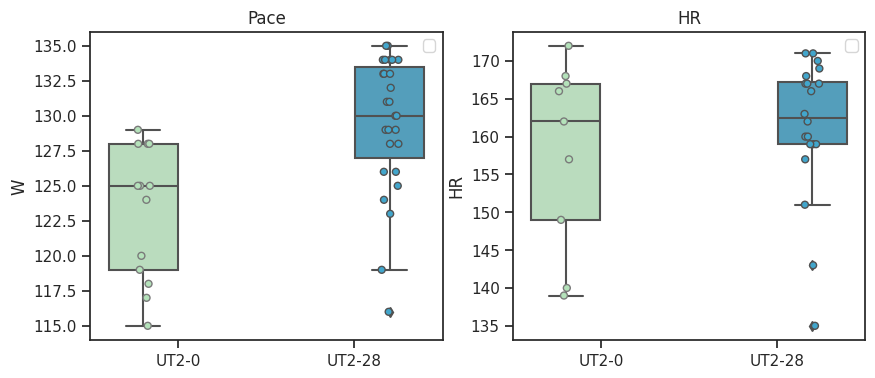

In [401]:
boxplot(df, "UT2")

# UT1

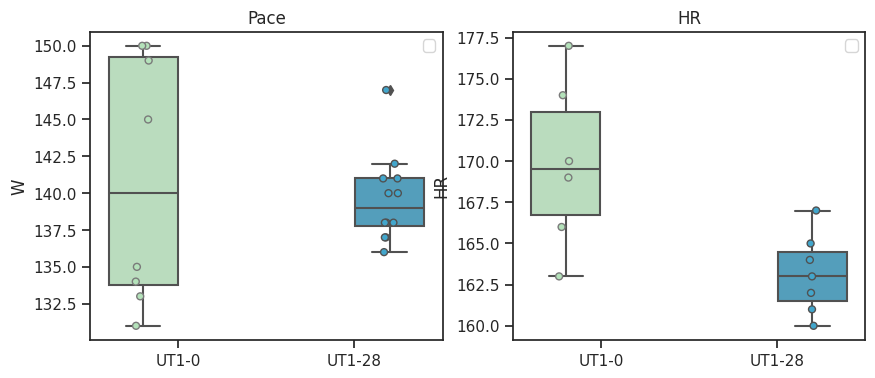

In [402]:
boxplot(df, "UT1")